# PiLoc

* Implementation of `PiLoc: a Self-Calibrating Participatory Indoor Localization System`

## Imports

In [1]:
import sys
import os

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(
    PROJECT_HOME, "code", "indoor-location-competition-20"
)
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The library is located at ./../../code/indoor-location-competition-20
The code is located in ./../../code


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from io_f import read_data_file
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.zee import create_search_grid, SearchGrid
from shapely import ops as shapely_ops
from shapely import vectorized as shapely_vectorized
from shapely.geometry import LineString
from py_indoor_loc.plot import plot_floor_map
from py_indoor_loc.sensors import estimate_acceleration_heading
from py_indoor_loc.pdr.step_detection import compute_mean, compute_local_acc_variance, compute_step_positions
from compute_f import compute_step_heading
from compute_f import compute_rel_positions
from compute_f import correct_positions
from scipy.interpolate import interp1d
from dataclasses import dataclass

In [3]:
%matplotlib inline

## Utilities

In [4]:
def get_track_filepaths(assignment_df: pd.DataFrame, base_data_dir: str, suffix: str = ".txt") -> list[str]:

  if not base_data_dir.endswith("/"):
    base_data_dir += "/"
  
  result = []

  for _, row in assignment_df.iterrows():
    file_path = f"{base_data_dir}{row['site_id']}/{row['floor_id']}/{row['track_id']}{suffix}"
    if not os.path.exists(file_path):
      print(f"File {file_path} does not exist.")
      continue
    result.append(file_path)
    
  return result

## Env Variables

In [5]:
TRAIN_DATA_DIR = "../../data/train/"
SUPERVISION_PCT = 0.1

In [6]:
WIFI_DATA_DIR = "../../data/wifi_fingerprint_manual/train/"

## Read Train/Test Assignment

In [7]:
supervision_df = pd.read_csv("../../data/output/20230903_semi_supervision_setup.csv", index_col=0)
supervision_df["site_id"] = supervision_df["site_id"].astype("category")
supervision_df["floor_id"] = supervision_df["floor_id"].astype("category")
supervision_df["dataset"] = supervision_df["dataset"].astype("category")


In [6]:
train_test_assignment = pd.read_csv("../../data/output/20230903_train_test_assignment.csv")
train_test_assignment["site_id"] = train_test_assignment["site_id"].astype("category")
train_test_assignment["floor_id"] = train_test_assignment["floor_id"].astype("category")
train_test_assignment["dataset"] = train_test_assignment["dataset"].astype("category")

In [10]:
supervision_floor_df = supervision_df.loc[
    (supervision_df["supervision_pct"] == SUPERVISION_PCT) &
    (supervision_df["dataset"] == "unlabeled")]

unique_floors = supervision_floor_df[["site_id", "floor_id"]].drop_duplicates().values

print("The number of floors:", unique_floors.shape[0])
print("The number of tracks:", supervision_floor_df.shape[0])

The number of floors: 137
The number of tracks: 6284


## PiLoc: Data Collection

* Data collection is the first step of PiLoc.
* Each trajectory is determined by a sequency of steps, i.e. the i-th trajectory $T_i = [s_1, s_2,..., s_n]$, in which $s_i$ is a discrete walking step detected by the linear accelerations from the corresponding phone accelerometer input.
* Each step $s_i$ consists for 4 elements: $s_i = (id_i, x_i, y_i, f_i)$
  * $id_i$ is the global step identifier.
  * $x_i$ and $y_i$ are the relative physical 2D position of the current step with respect to the initial step $s_1$
  * $f_i = (r_1, r_2, ..., r_k)$ represents the WiFi RSS measured at step $i$, where $r_j$ is the received signal strength of $AP_j$ detected.

### Reading Data

In [39]:
site_id, floor_id = unique_floors[10]

train_tracks = supervision_floor_df.loc[
    (supervision_floor_df["site_id"] == site_id) &
    (supervision_floor_df["floor_id"] == floor_id)]

test_tracks = train_test_assignment.loc[
    (train_test_assignment["site_id"] == site_id) &
    (train_test_assignment["floor_id"] == floor_id) &
    (train_test_assignment["dataset"] == "test")]

train_files = get_track_filepaths(train_tracks, base_data_dir=TRAIN_DATA_DIR)
test_files = get_track_filepaths(test_tracks, base_data_dir=TRAIN_DATA_DIR)

In [234]:
wifi_train_files = get_track_filepaths(train_tracks, base_data_dir=WIFI_DATA_DIR, suffix="_wifi_fingerprint.csv")

* Read data files for a specific sites

In [8]:
site_id, floor_id = "5cd56b6ae2acfd2d33b59ccb", "F2"

In [9]:
data_files = glob(f"{TRAIN_DATA_DIR}{site_id}/{floor_id}/*.txt")

* Read floor map data

In [10]:
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

In [11]:
path_datas = read_data_file(data_files[0])

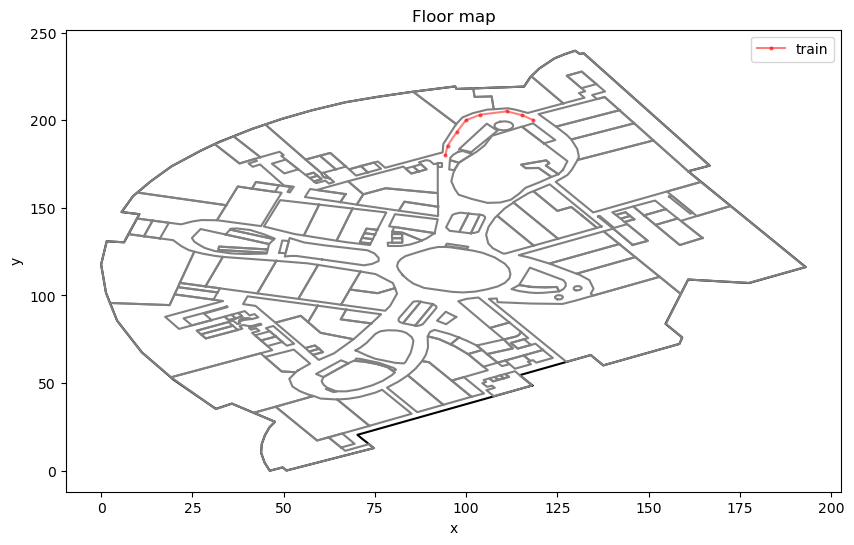

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(path_datas.waypoint[:, 1:])
ax.plot(waypoint_location[:, 0],
        waypoint_location[:, 1],
        marker="o",
        markersize=2,
        color="red",
        label="train",
        alpha=0.5)
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

### Step Detection

In [13]:
def compute_random_stride_length(size: int,
                                 stride_length_range: tuple[float, float] = (0.5, 1.2),
                                 noise_pct: float = 0.15) -> np.ndarray:
  assert noise_pct >= 0 and noise_pct <= 1

  sl_low, sl_high = stride_length_range
  noise = np.random.normal(loc=0, scale=noise_pct, size=size)
  stride_length = np.random.uniform(low=sl_low, high=sl_high, size=size)
  return stride_length * (1 + noise)

In [67]:
def create_sensor_df(path_datas) -> pd.DataFrame:
  magn_df = pd.DataFrame(path_datas.magn, columns=["ts", "magn_x", "magn_y", "magn_z"])
  acce_df = pd.DataFrame(path_datas.acce, columns=["ts", "acce_x", "acce_y", "acce_z"])
  sensor_df = pd.merge(acce_df, magn_df, how="outer")
  sensor_df.dropna(inplace=True)
  sensor_df.ffill(inplace=True)
  sensor_df["ts"] = sensor_df["ts"].astype(np.int64)
  sensor_df.sort_values("ts", ascending=True, inplace=True)
  return sensor_df

In [68]:
sensor_df = create_sensor_df(path_datas)
acce, heading = estimate_acceleration_heading(acce=sensor_df[["ts", "acce_x", "acce_y", "acce_z"]].values,
                                              magn=sensor_df[["ts", "magn_x", "magn_y", "magn_z"]].values)
acce_magnitudes = np.linalg.norm(acce, axis=1)

acce_mean = compute_mean(acce_magnitudes, window_size=5)
acce_var  = compute_local_acc_variance(acce_magnitudes, window_size=5)
step_flags, swing, stance = compute_step_positions(acce_var, swing_threshold=2.0, stance_threshold=1.0, window_size=5)

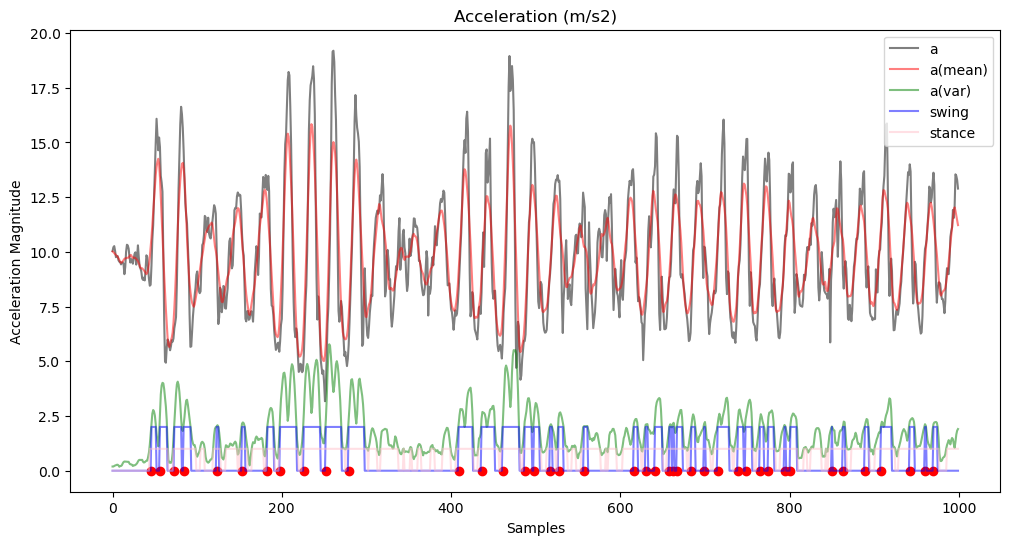

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

n_samples = 1000
ax.plot(acce_magnitudes[:n_samples], alpha=0.5, label="a", color="black")
ax.plot(acce_mean[:n_samples], alpha=0.5, label="a(mean)", color="red")
ax.plot(acce_var[:n_samples], alpha=0.5, label="a(var)", color="green")
ax.plot(swing[:n_samples], alpha=0.5, label="swing", color="blue")
ax.plot(stance[:n_samples], alpha=0.5, label="stance", color="pink")

for i in range(n_samples):
  if step_flags[i]:
    ax.scatter(i, 0, marker="o", color="red")

ax.set_title("Acceleration (m/s2)")
ax.set_xlabel("Samples")
ax.set_ylabel("Acceleration Magnitude")
ax.legend()

plt.show()

In [50]:
sensor_timestamps = sensor_df["ts"].values
heading_with_timestamps = np.vstack((sensor_timestamps, heading)).T
step_timestamps = sensor_timestamps[step_flags]
step_headings = compute_step_heading(step_timestamps, heading_with_timestamps)
step_headings[:, 1] = np.radians(step_headings[:, 1])
stride_lengths = np.zeros((len(step_timestamps), 2), dtype=np.float64)
stride_lengths[:, 0] = step_timestamps
stride_lengths[:, 1] = compute_random_stride_length(len(step_timestamps))
rel_positions = compute_rel_positions(stride_lengths, step_headings)
step_locations = correct_positions(rel_positions, path_datas.waypoint)

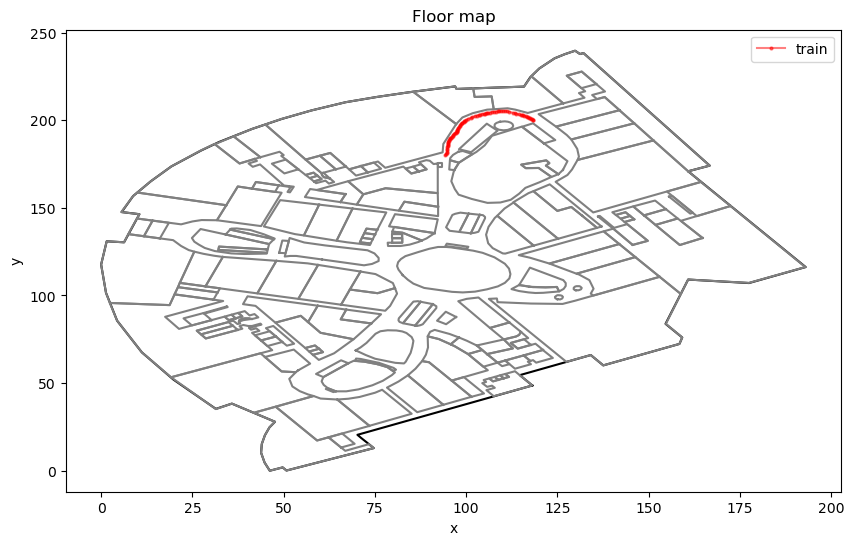

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(step_locations[:, 1:])
ax.plot(waypoint_location[:, 0],
        waypoint_location[:, 1],
        marker="o",
        markersize=2,
        color="red",
        label="train",
        alpha=0.5)
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

In [24]:
from py_indoor_loc.pdr import filter_headings, detect_turn_points

In [100]:
def moving_average(x: np.ndarray, w: int) -> np.ndarray:
  return np.convolve(x, np.ones(w), 'valid') / w


In [57]:
turn_point_mask = detect_turn_points(filter_headings(step_headings[:, 1]))

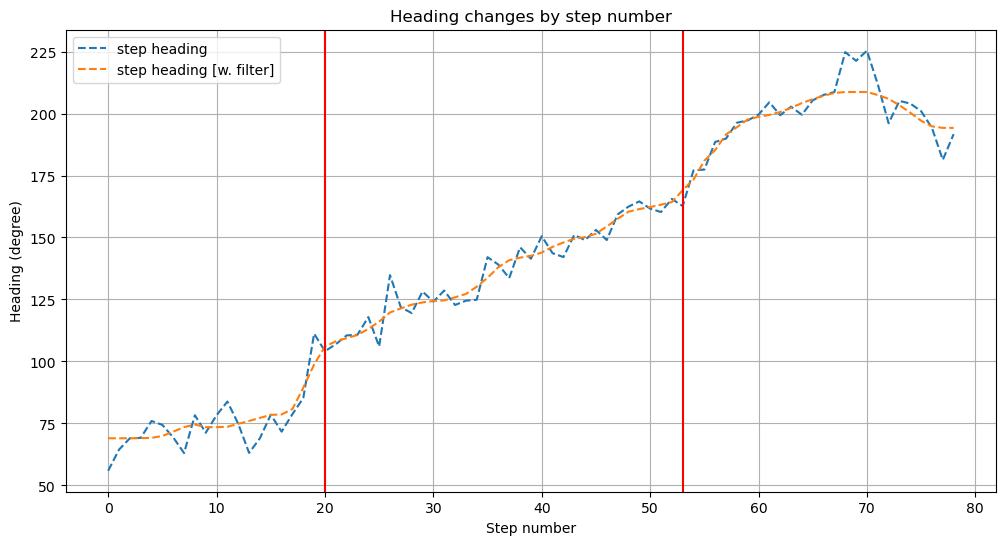

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(np.degrees(step_headings[:, 1]), label="step heading", ls="--")
ax.plot(np.degrees(filter_headings(step_headings[:, 1])), label="step heading [w. filter]", ls="--")

for x in np.where(turn_point_mask)[0]:
  ax.axvline(x=x, color="red")

ax.set_xlabel("Step number")
ax.set_ylabel("Heading (degree)")
ax.set_title("Heading changes by step number")
ax.grid()
ax.legend()

plt.show()

In [62]:
turn_indices = np.where(turn_point_mask)[0]

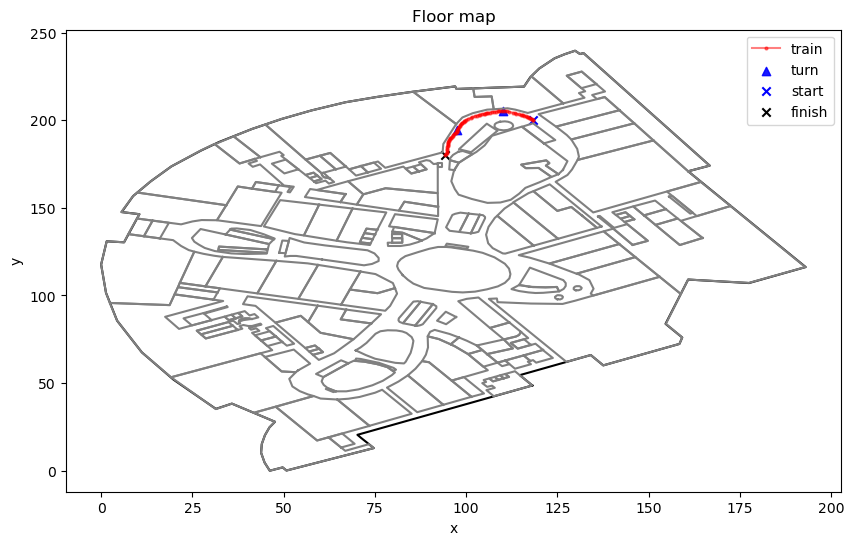

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(step_locations[:, 1:])

ax.plot(waypoint_location[:, 0],
        waypoint_location[:, 1],
        marker="o",
        markersize=2,
        color="red",
        label="train",
        alpha=0.5)

ax.scatter(waypoint_location[turn_indices, 0],
           waypoint_location[turn_indices, 1],
           marker="^",
           color="blue",
           label="turn",
           alpha=0.9)

ax.scatter(waypoint_location[:1, 0],
           waypoint_location[:1, 1],
           marker="x",
           color="blue",
           label="start",
           alpha=1.0)

ax.scatter(waypoint_location[-1:, 0],
           waypoint_location[-1:, 1],
           marker="x",
           color="black",
           label="finish",
           alpha=1.0)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

* Segment Extraction

In [64]:
def split_segments(n_steps: int,
                   turn_indices: np.ndarray,
                   turn_window_n_steps: int = 10,
                   straight_line_min_n_steps: int = 30) -> list:

  turn_mask = np.array([False] * n_steps)
  for turn_index in turn_indices:
    turn_mask[turn_index - turn_window_n_steps:turn_index +
              turn_window_n_steps] = True

  step_flag_straight_line = False
  step_flag_turn = True

  segment_type = {True: "turn", False: "straight_line"}

  segments = []

  step_idx = 0
  step_flag = turn_mask[step_idx]
  step_start_idx, step_stop_idx = step_idx, step_idx

  while step_idx + 1 < n_steps:
    step_idx += 1
    if turn_mask[step_idx] == step_flag:
      step_stop_idx += 1
    else:
      if (step_flag == step_flag_straight_line and step_stop_idx - step_start_idx >= straight_line_min_n_steps) \
        or (step_flag == step_flag_turn):
        segments.append(
            (step_start_idx, step_stop_idx, segment_type[step_flag]))

      step_flag = turn_mask[step_idx]
      step_start_idx, step_stop_idx = step_idx, step_idx


  if (step_flag == step_flag_straight_line and step_stop_idx - step_start_idx >= straight_line_min_n_steps) \
        or (step_flag == step_flag_turn):
    segments.append((step_start_idx, step_stop_idx, segment_type[step_flag]))

  return segments


In [65]:
segments = split_segments(len(step_timestamps), turn_indices)

In [66]:
segments

[(10, 29, 'turn'), (43, 62, 'turn')]

## PiLoc: Matching

### Path Correlation

In [102]:
def downsample(arr: np.ndarray,
               downsampling_factor: float = 2,
               kind: str = "linear") -> np.ndarray:
  interp_func = interp1d(np.arange(len(arr)), arr, kind=kind)
  new_indices = np.arange(0, len(arr) - 1, downsampling_factor)
  return interp_func(new_indices)


In [103]:
def compute_path_correlation(s1_x: np.ndarray, s1_y: np.ndarray,
                             s2_x: np.ndarray, s2_y: np.ndarray,) -> float:
  n1, n2 = len(s1_x), len(s2_x)

  if n1 > n2:
    return compute_path_correlation(s2_x, s2_y, s1_x, s1_y)
  
  # Perform downsampling to align the longer sequence
  downsampling_factor = n2 / n1
  d_s2_x = downsample(s2_x, downsampling_factor, "linear")
  d_s2_y = downsample(s2_y, downsampling_factor, "linear")

  n = min(n1, len(d_s2_x))
  corr_x = np.corrcoef(s1_x[:n], d_s2_x[:n])[0, 1]
  corr_y = np.corrcoef(s1_y[:n], d_s2_y[:n])[0, 1]

  return corr_x + corr_y
  

In [104]:
start_idx, stop_idx = 45, 101
s1 = rel_positions[start_idx:stop_idx + 1]
s1_gt = step_locations[start_idx:stop_idx + 1]

In [105]:
start_idx, stop_idx = 168, 249
s2 = rel_positions[start_idx:stop_idx + 1]
s2_gt = step_locations[start_idx:stop_idx + 1]

### Signal Correlation

In [101]:
from py_indoor_loc.extract.wifi_fingerprint import read_wifi_location_df_list
from py_indoor_loc.extract.wifi_fingerprint import extract_bssid_set, create_fingerprint_vector

In [236]:
wifi_location_df_list = read_wifi_location_df_list(wifi_train_files)

In [241]:
bssid_vector = extract_bssid_set(wifi_location_df_list)
bssid_vector = np.array(list(bssid_vector))

In [242]:
fingerprint_tuples = []

for (sys_ts, x, y), group_data in wifi_location_df_list[0].groupby(["sys_ts", "x", "y"]):
  fingerprint_vector = create_fingerprint_vector(
      group_data, bssid_vector, ap_not_seen_rss=-100)
  fingerprint_tuples.append((sys_ts, x, y, fingerprint_vector))
fingerprint_df = pd.DataFrame(fingerprint_tuples, columns=["sys_ts", "x", "y", "v"])
fingerprint_df.sort_values("sys_ts", inplace=True)

In [257]:
F = np.vstack(fingerprint_df["v"].values)

In [249]:
f_timestamps = fingerprint_df["sys_ts"].values

In [260]:
start_idx, stop_idx = segments[1][0], segments[1][1]
m = (f_timestamps >= step_timestamps[start_idx]) & ((f_timestamps <= step_timestamps[stop_idx]))
s1_f = F[m]

In [261]:
start_idx, stop_idx = segments[3][0], segments[3][1]
m = (f_timestamps >= step_timestamps[start_idx]) & ((f_timestamps <= step_timestamps[stop_idx]))
s2_f = F[m]

In [108]:
def downsample_f(sf: np.ndarray, downsampling_factor: float = 2.0):
  downsampled = []

  for i in range(sf.shape[1]):
    downsampled.append(downsample(sf[:, i], downsampling_factor, kind="nearest"))
  
  return np.vstack(downsampled).T

In [109]:
assert downsample_f(s2_f, len(s2_f) / len(s1_f)).shape == s1_f.shape

NameError: name 's2_f' is not defined

In [110]:
def compute_signal_correlation(s1_f: np.ndarray, s2_f: np.ndarray,
                               min_n_apps: int = 10,
                               default_rss: float = -100,
                               rss_sigma: float = 5):
  if len(s1_f) > len(s2_f):
    return compute_signal_correlation(s2_f, s1_f, min_n_apps, default_rss, rss_sigma)

  # Aligning two RSS fingerprint signal  
  downsampling_factor = len(s2_f) / len(s1_f)
  s2_f = downsample_f(s2_f, downsampling_factor)
  n = min(len(s1_f), len(s2_f))
  s1_f, s2_f = s1_f[:n], s2_f[:n]

  mu1 = s1_f.mean(axis=0)
  mu2 = s2_f.mean(axis=0)
  s1_ap_n_apps = np.count_nonzero(s1_f > default_rss, axis=0)
  s2_ap_n_apps = np.count_nonzero(s2_f > default_rss, axis=0)

  total_ap_n_apps = s1_ap_n_apps + s2_ap_n_apps
  selected_ap = (total_ap_n_apps >= min_n_apps) & (s1_ap_n_apps > 0) & (s2_ap_n_apps > 0)
  selected_ap_indices = np.where(selected_ap)[0]

  if len(selected_ap_indices) == 0:
    return 0.0

  corr_signal = 0.0
  for i in selected_ap_indices:
    i_12 = np.abs(mu1[i] - mu2[i]) < rss_sigma
    w = 2.0 / np.abs(mu1[i] + mu2[i])
    if s1_f[:, i].std() == 0 or s2_f[:, i].std() == 0:
      continue
    f_corr = np.corrcoef(s1_f[:, i], s2_f[:, i])[0, 1]
    corr_signal += w * f_corr * i_12
    
  return corr_signal

In [437]:
compute_signal_correlation(s1_f, s2_f)

-0.2950048968871923

In [439]:
compute_signal_correlation(s1_f, s2_f[::-1])

0.5534259765407322

## Matching

In [76]:
def to_text(v: np.ndarray, sep: str = ","):
  return sep.join([str(vv) for vv in v])


def to_array(v_text: str, sep: str = ",") -> np.ndarray:
  return np.array([float(vv) for vv in v_text.split(sep)], dtype=np.float32)

In [85]:
def create_matrix(wifi_fingerprint_location_df):
  
  F = np.vstack(wifi_fingerprint_location_df["v"].values.tolist())

  m = np.zeros((F.shape[0], F.shape[1] + 1))
  m[:, 0] = wifi_fingerprint_location_df["sys_ts"].values
  m[:, 1:] = F

  return m

In [94]:
@dataclass
class Segment(object):
  track_id: str
  rel_step_positions: np.ndarray
  wifi_f: np.ndarray  
  kind: str

  step_positions: np.ndarray

In [97]:
result = []

for data_file in tqdm(data_files):

  path_datas = read_data_file(data_file)

  sensor_df = create_sensor_df(path_datas)
  acce, heading = estimate_acceleration_heading(acce=sensor_df[["ts", "acce_x", "acce_y", "acce_z"]].values,
                                                magn=sensor_df[["ts", "magn_x", "magn_y", "magn_z"]].values)
  acce_magnitudes = np.linalg.norm(acce, axis=1)

  acce_mean = compute_mean(acce_magnitudes, window_size=5)
  acce_var  = compute_local_acc_variance(acce_magnitudes, window_size=5)
  step_flags, swing, stance = compute_step_positions(acce_var, swing_threshold=2.0, stance_threshold=1.0, window_size=5)

  sensor_timestamps = sensor_df["ts"].values
  heading_with_timestamps = np.vstack((sensor_timestamps, heading)).T
  step_timestamps = sensor_timestamps[step_flags]
  step_headings = compute_step_heading(step_timestamps, heading_with_timestamps)
  step_headings[:, 1] = np.radians(step_headings[:, 1])
  stride_lengths = np.zeros((len(step_timestamps), 2), dtype=np.float64)
  stride_lengths[:, 0] = step_timestamps
  stride_lengths[:, 1] = compute_random_stride_length(len(step_timestamps))
  rel_positions = compute_rel_positions(stride_lengths, step_headings)

  turn_point_mask = detect_turn_points(filter_headings(step_headings[:, 1]))
  turn_indices = np.where(turn_point_mask)[0]

  segments = split_segments(len(step_timestamps), turn_indices)
  track_id = os.path.basename(data_file[:-len(".txt")])
  wifi_fingerprint_location_df = pd.read_csv(f"../../data/wifi_location/{site_id}/{floor_id}/{track_id}.csv", sep="|",)
  wifi_fingerprint_location_df["v"] = wifi_fingerprint_location_df["v"].apply(lambda vv: to_array(vv, sep=","))
  Fm = create_matrix(wifi_fingerprint_location_df)

  for s_start_idx, s_end_idx, s_type in segments:
    segment = Segment(track_id, 
                      rel_step_positions=rel_positions[s_start_idx:s_end_idx+1, :],
                      wifi_f=Fm[(Fm[:, 0] >= step_timestamps[s_start_idx]) & (Fm[:, 0] <= step_timestamps[s_end_idx])],
                      kind=s_type,
                      step_positions=step_positions[s_start_idx:s_end_idx+1, :])
    
    result.append(segment)

100%|██████████| 132/132 [00:22<00:00,  5.75it/s]


In [99]:
len(result)

273

* Floor plan construction

In [115]:
turn_segments = []

for segment in result:
  if segment.kind == "turn":
    turn_segments.append(segment)

In [116]:
compute_path_correlation(turn_segments[0].rel_step_positions[:, 1], turn_segments[0].rel_step_positions[:, 2], 
                         turn_segments[1].rel_step_positions[:, 1], turn_segments[1].rel_step_positions[:, 2], )

0.6329760888101847

In [121]:
compute_signal_correlation(turn_segments[0].wifi_f[:, 1:], turn_segments[-10].wifi_f[:, 1:],)

0.0

In [123]:
turn_segments[-10].wifi_f[:, 1:].shape

(4, 2560)

In [130]:
compute_signal_correlation(turn_segments[0].wifi_f[:, 1:], turn_segments[100].wifi_f[:, 1:],)

0.0

In [131]:
turn_segments[100].wifi_f[:, 1:].shape

(6, 2560)

In [132]:
turn_segments[0].wifi_f[:, 1:].shape

(9, 2560)